<a href="https://colab.research.google.com/github/SujithSajeev-17/Deep_Learning/blob/main/Pharmaceutical_Drugs_and_Vitamins_Classification_using_mobilenetv2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!cp "/content/drive/MyDrive/Pharmaceutical drugs and vitamins.zip" '/content'

In [2]:
!unzip '/content/Pharmaceutical drugs and vitamins.zip'

Streaming output truncated to the last 5000 lines.
  inflating: ImageClassesCombinedWithCOCOAnnotations/images_raw/00005002.jpg  
  inflating: ImageClassesCombinedWithCOCOAnnotations/images_raw/00005003.jpg  
  inflating: ImageClassesCombinedWithCOCOAnnotations/images_raw/00005004.jpg  
  inflating: ImageClassesCombinedWithCOCOAnnotations/images_raw/00005005.jpg  
  inflating: ImageClassesCombinedWithCOCOAnnotations/images_raw/00005006.jpg  
  inflating: ImageClassesCombinedWithCOCOAnnotations/images_raw/00005007.jpg  
  inflating: ImageClassesCombinedWithCOCOAnnotations/images_raw/00005008.jpg  
  inflating: ImageClassesCombinedWithCOCOAnnotations/images_raw/00005009.jpg  
  inflating: ImageClassesCombinedWithCOCOAnnotations/images_raw/00005010.jpg  
  inflating: ImageClassesCombinedWithCOCOAnnotations/images_raw/00005011.jpg  
  inflating: ImageClassesCombinedWithCOCOAnnotations/images_raw/00005012.jpg  
  inflating: ImageClassesCombinedWithCOCOAnnotations/images_raw/00005013.jpg  
 

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import tensorflow as tf
from tensorflow.keras import layers,Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import Callback,EarlyStopping,ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import mobilenet_v2,MobileNetV2
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics  import classification_report,confusion_matrix

In [4]:
# from google.colab import drive
# drive.mount('/content/drive')

In [5]:
dataset = "/content/Drug Vision/Data Combined"


image_dir = Path(dataset)
filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.png')) + list(image_dir.glob(r'**/*.PNG'))  # Include both uppercase and lowercase extensions
labels = [path.parent.name for path in filepaths]

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')
image_df = pd.concat([filepaths, labels], axis=1)


In [6]:
image_df

Filepath     Label
0     /content/Drug Vision/Data Combined/Biogesic/00...  Biogesic
1     /content/Drug Vision/Data Combined/Biogesic/00...  Biogesic
2     /content/Drug Vision/Data Combined/Biogesic/00...  Biogesic
3     /content/Drug Vision/Data Combined/Biogesic/00...  Biogesic
4     /content/Drug Vision/Data Combined/Biogesic/00...  Biogesic
...                                                 ...       ...
9995  /content/Drug Vision/Data Combined/Bactidol/00...  Bactidol
9996  /content/Drug Vision/Data Combined/Bactidol/00...  Bactidol
9997  /content/Drug Vision/Data Combined/Bactidol/00...  Bactidol
9998  /content/Drug Vision/Data Combined/Bactidol/00...  Bactidol
9999  /content/Drug Vision/Data Combined/Bactidol/00...  Bactidol

[10000 rows x 2 columns]

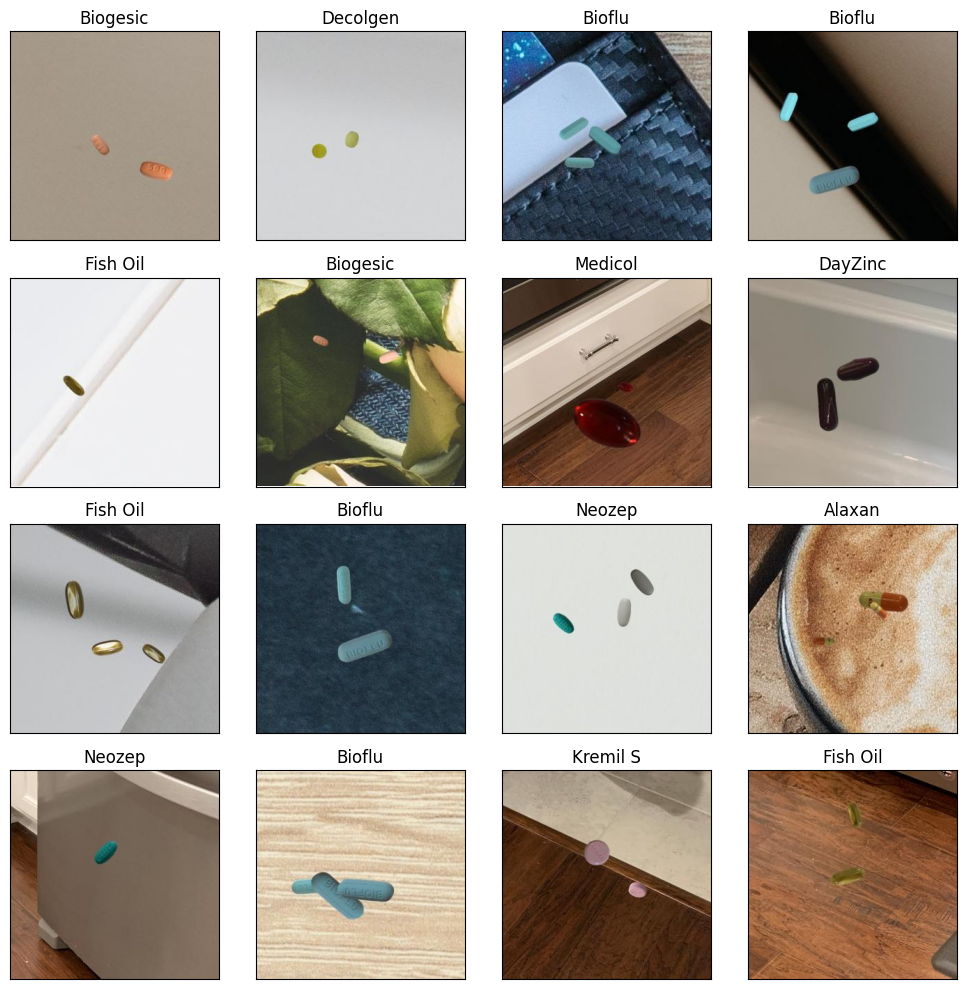

In [7]:
random_index = np.random.randint(0, len(image_df), 16)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[random_index[i]]))
    ax.set_title(image_df.Label[random_index[i]])
plt.tight_layout()
plt.show()

In [8]:
epochs = 1000

batch_size = 32

In [9]:
train_df,test_df = train_test_split(image_df,test_size=0.2,random_state=42)

In [10]:
train_generator = ImageDataGenerator(
    preprocessing_function = tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)

test_generator = ImageDataGenerator(
    preprocessing_function= tf.keras.applications.mobilenet_v2.preprocess_input
)

In [11]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False
)

Found 6400 validated image filenames belonging to 10 classes.
Found 1600 validated image filenames belonging to 10 classes.
Found 2000 validated image filenames belonging to 10 classes.


In [12]:
resize_and_rescale = Sequential([
  layers.experimental.preprocessing.Resizing(224,224),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [13]:
pretrained_model = MobileNetV2(
    input_shape = (224,224,3),
    include_top = False,
    weights ='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

9406464/9406464 [==============================] - 1s 0us/step


In [14]:
checkpoint_path = 'pharm_d_and_v_cls_checkpoints'
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor = 'val_accuracy',
                                      save_best_only=True)


In [15]:
early_stopping = EarlyStopping(monitor = 'val_loss',
                               patience=5,
                               restore_best_weights=True)

In [16]:
inputs = pretrained_model.input
x = resize_and_rescale(inputs)

x = Dense(256, activation='relu')(pretrained_model.output)
x = Dropout(0.2)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)


outputs = Dense(10, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

In [17]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [18]:
history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=100,
    callbacks=[
        early_stopping,
        checkpoint_callback,
    ]
)

Epoch 1/100
200/200 [==============================] - 25s 87ms/step - loss: 0.9967 - accuracy: 0.6589 - val_loss: 0.6011 - val_accuracy: 0.7944
Epoch 2/100
200/200 [==============================] - 17s 84ms/step - loss: 0.5254 - accuracy: 0.8141 - val_loss: 0.5650 - val_accuracy: 0.8019
Epoch 3/100
200/200 [==============================] - 20s 102ms/step - loss: 0.4252 - accuracy: 0.8527 - val_loss: 0.5040 - val_accuracy: 0.8219
Epoch 4/100
200/200 [==============================] - 19s 93ms/step - loss: 0.3427 - accuracy: 0.8808 - val_loss: 0.5041 - val_accuracy: 0.8325
Epoch 5/100
200/200 [==============================] - 16s 81ms/step - loss: 0.2986 - accuracy: 0.8941 - val_loss: 0.4710 - val_accuracy: 0.8425
Epoch 6/100
200/200 [==============================] - 16s 79ms/step - loss: 0.2605 - accuracy: 0.9080 - val_loss: 0.4889 - val_accuracy: 0.8369
Epoch 7/100
200/200 [==============================] - 20s 97ms/step - loss: 0.2022 - accuracy: 0.9264 - val_loss: 0.4996 - val_a

In [19]:
# model = Sequential()
# model.add(Conv2D(filters=32,kernel_size=(3,3),activation='relu',input_shape=(image_size[0],image_size[1],3)))
# model.add(MaxPooling2D(pool_size=(2,2)))
# model.add(Flatten())
# model.add(Dense(units=256,activation='relu'))
# model.add(Dense(units=10,activation='softmax'))m


In [20]:
results = model.evaluate(test_images,verbose=[0])
print("Test Accuracy: {:.2f}%".format(results[1]))


Test Accuracy: 0.84%


In [21]:
pred = model.predict(test_images,verbose=[0])
pred = np.argmax(pred,axis=1)

labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

print(f'first 5 predictions: {pred[:5]}')

first 5 predictions: ['Neozep', 'Fish Oil', 'Neozep', 'Fish Oil', 'Fish Oil']


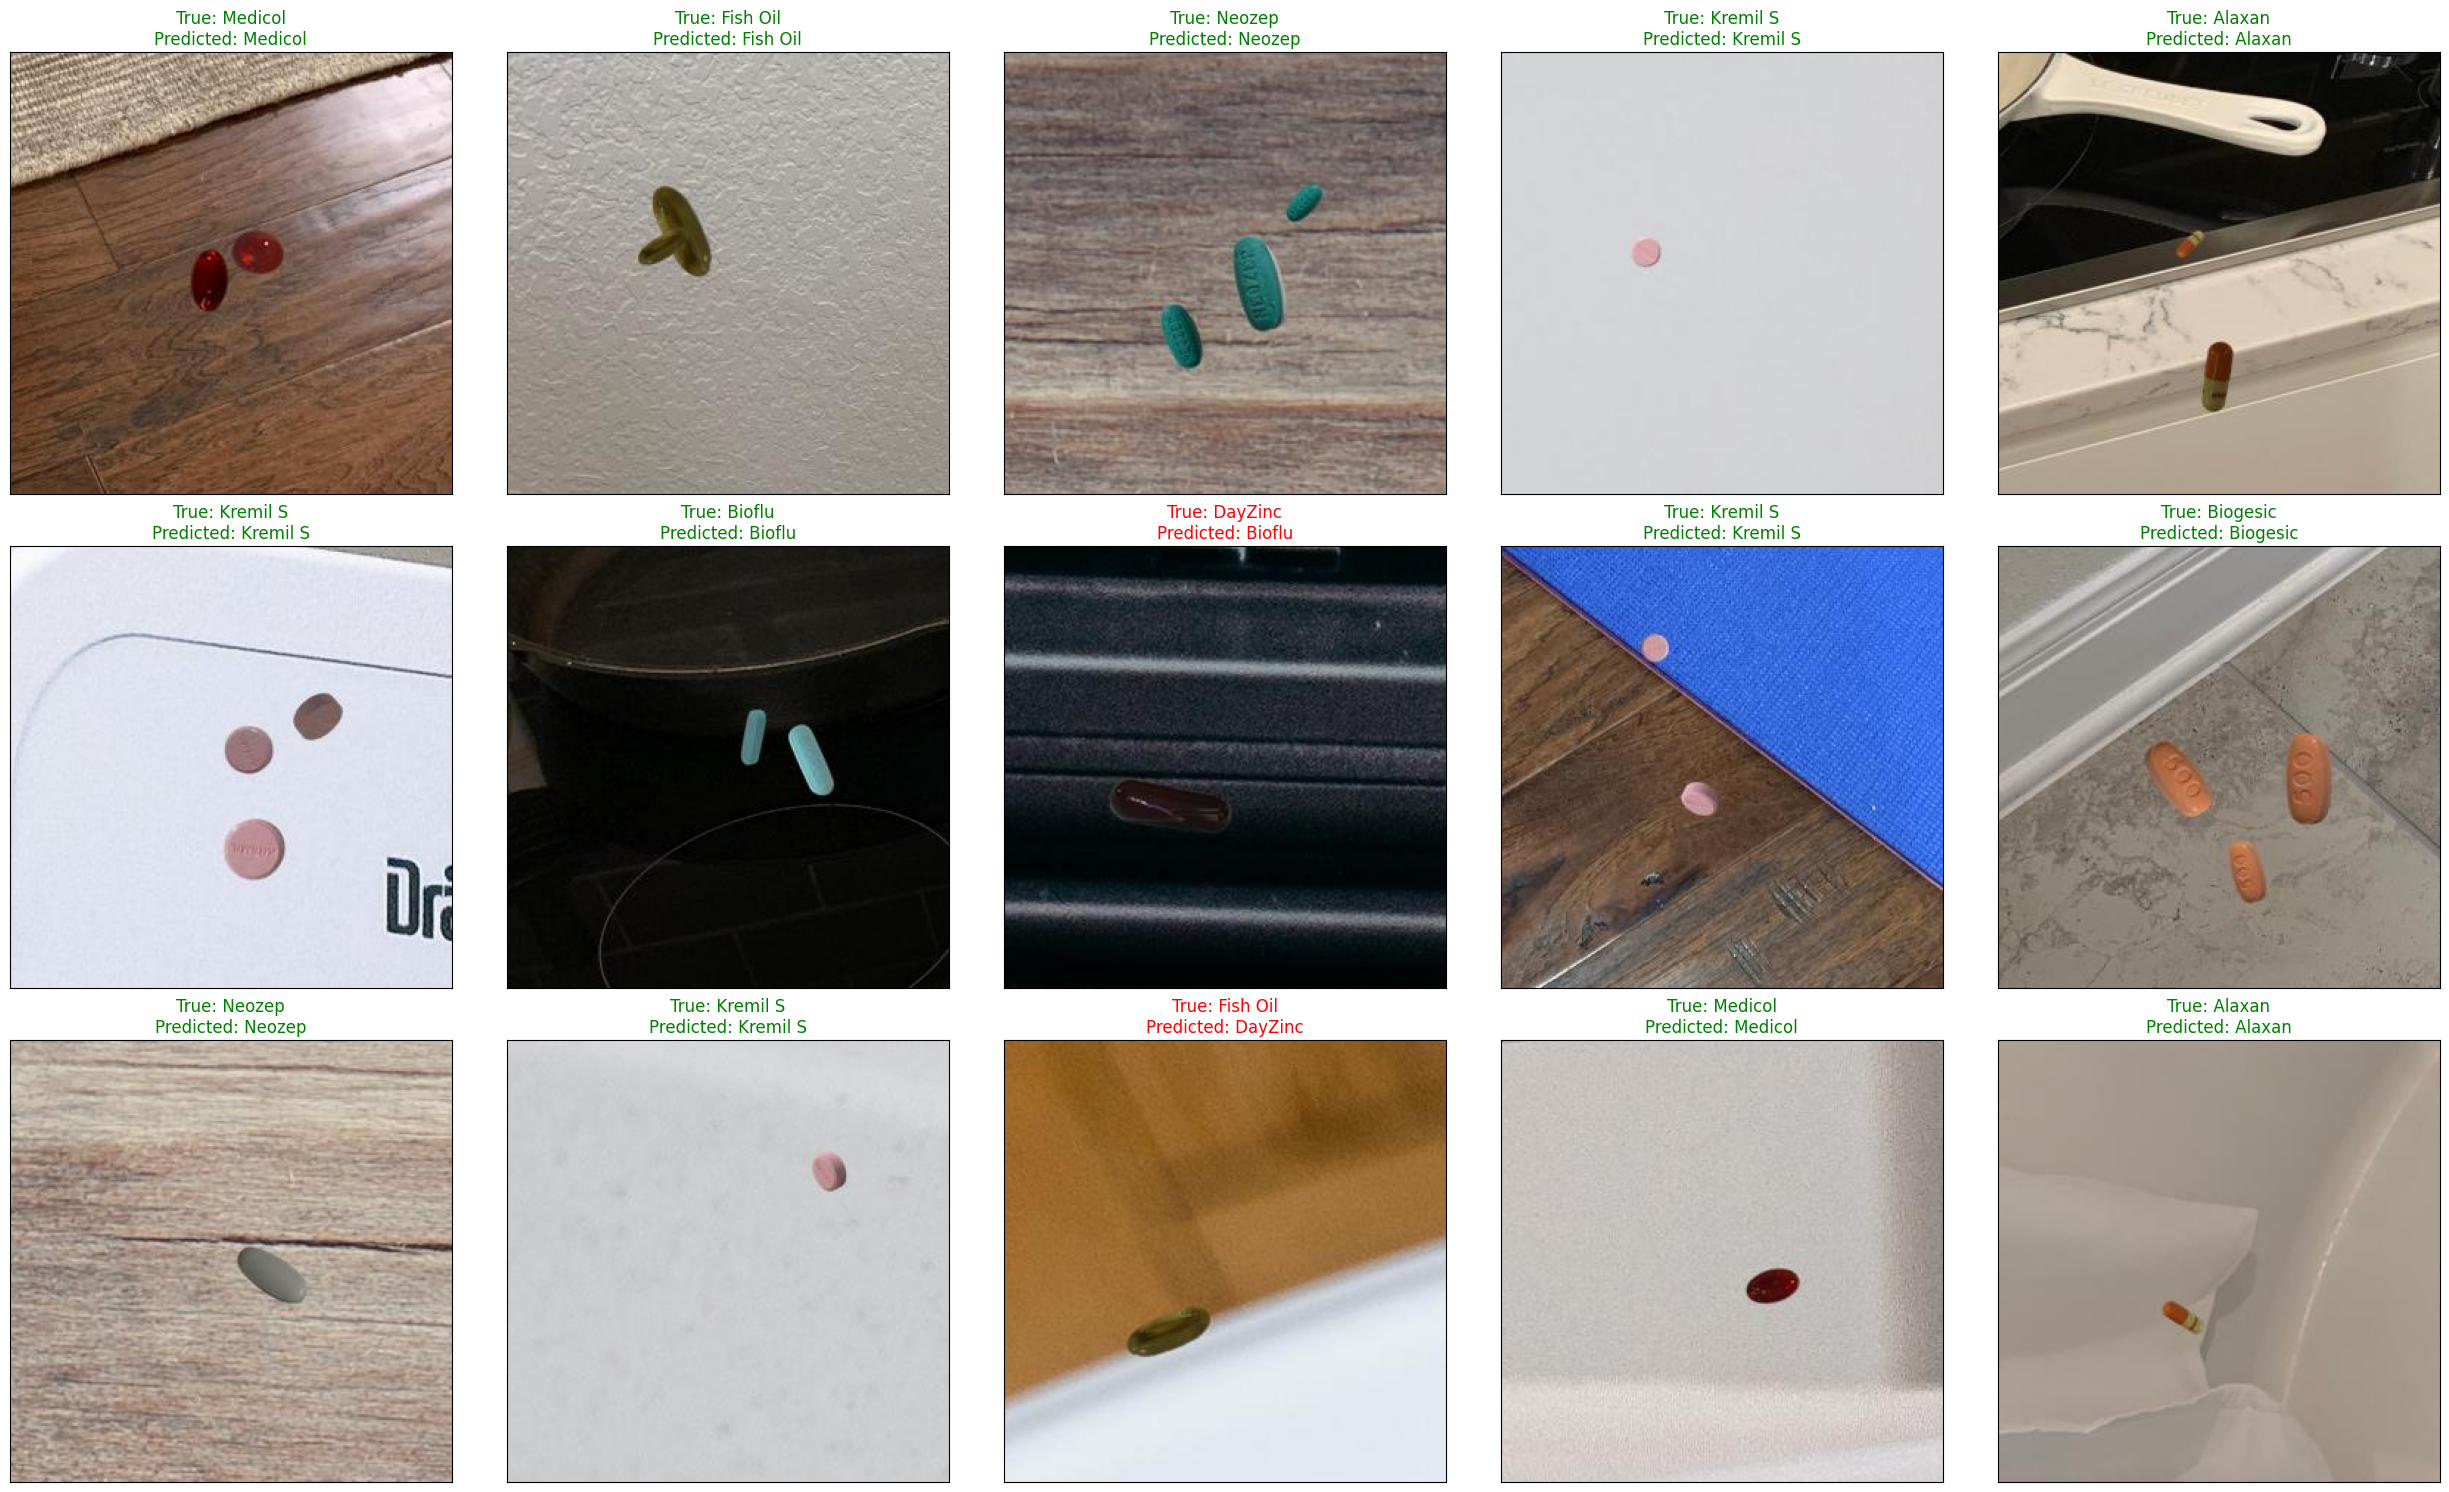

In [22]:
random_index = np.random.randint(0, len(test_df) - 1, 15)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15), subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[random_index[i]]))
    if test_df.Label.iloc[random_index[i]] == pred[random_index[i]]:
      color = "green"
    else:
      color = "red"
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)
plt.tight_layout()
plt.show()


In [23]:
y_test = test_df.Label
report = pd.DataFrame(classification_report(y_test,pred,output_dict=True)).T
report

precision    recall  f1-score   support
Alaxan         0.796020  0.860215  0.826873   186.000
Bactidol       0.878205  0.782857  0.827795   175.000
Bioflu         0.889447  0.876238  0.882793   202.000
Biogesic       0.759434  0.774038  0.766667   208.000
DayZinc        0.810573  0.901961  0.853828   204.000
Decolgen       0.926554  0.854167  0.888889   192.000
Fish Oil       0.894231  0.889952  0.892086   209.000
Kremil S       0.750000  0.834906  0.790179   212.000
Medicol        0.949495  0.935323  0.942356   201.000
Neozep         0.817204  0.720379  0.765743   211.000
accuracy       0.843000  0.843000  0.843000     0.843
macro avg      0.847116  0.843004  0.843721  2000.000
weighted avg   0.845902  0.843000  0.843125  2000.000

In [24]:
cm = confusion_matrix(y_test,pred)
cm

array([[160,   1,   0,  10,   3,   2,   3,   3,   2,   2],
       [  1, 137,   1,   7,   2,   3,   2,  16,   4,   2],
       [  4,   0, 177,   4,   1,   0,   0,   0,   0,  16],
       [ 14,   6,   2, 161,   4,   1,   3,  15,   0,   2],
       [  2,   0,   1,   1, 184,   0,   4,   4,   3,   5],
       [  4,   2,   1,   2,   1, 164,   3,  13,   0,   2],
       [  3,   0,   0,   3,  14,   1, 186,   0,   0,   2],
       [  2,   7,   0,  16,   1,   4,   1, 177,   1,   3],
       [  4,   3,   0,   0,   2,   0,   0,   4, 188,   0],
       [  7,   0,  17,   8,  15,   2,   6,   4,   0, 152]])

In [27]:
model.save('d_and_v_cls.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [28]:
from tensorflow.keras.preprocessing import image
import numpy as np

In [38]:
def preprocess_image(image_path):
    img = image.load_img(image_path, target_size=(224,224))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = img / 255.0
    return img


def predict_image(image_path):
    img = preprocess_image(image_path)
    prediction = model.predict(img)
    predicted_class_index= np.argmax(prediction, axis=1)[0]
    labels = (train_images.class_indices)
    labels = dict((v, k) for k, v in labels.items())
    predicted_class = labels[predicted_class_index]
    return predicted_class

In [39]:
image_path = '/content/images (7).jpeg'
predicted_class = predict_image(image_path)
print("Predicted class:", predicted_class)

1/1 [==============================] - 0s 21ms/step
Predicted class: Fish Oil
